# Experiment 7: System Prompt Combination Effects

**Goal:** Test how combining multiple instructions in system prompts affects behavior.

**Setup:**
- Fixed test prompts
- Individual instructions vs combinations
- Measure: Do effects stack? Conflict? Cancel out?

In [1]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
from itertools import combinations
from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [3]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Define Individual Instructions

In [4]:
INDIVIDUAL_INSTRUCTIONS = {
    "concise": "Be concise.",
    "accurate": "Be accurate.",
    "helpful": "Be helpful.",
    "cot": "Think step by step.",
    "confident": "Be confident.",
    "cautious": "Be cautious about uncertainty.",
}

# Potentially conflicting pairs
CONFLICT_PAIRS = [
    ("concise", "cot"),  # Short vs detailed reasoning
    ("confident", "cautious"),  # Opposite attitudes
]

# Potentially synergistic pairs
SYNERGY_PAIRS = [
    ("accurate", "cautious"),
    ("helpful", "cot"),
]

## 2. Test Individual vs Combined

In [8]:
TEST_SUBSET = ALL_TEST_PROMPTS[:10]

def test_combinations(model, test_prompts, instructions):
    results = []
    
    # Baseline (no instruction)
    for test in test_prompts:
        prompt = build_chat_prompt("", test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        results.append({
            "config": "none",
            "test_id": test["id"],
            "entropy": dist["entropy"],
            "full_probs": dist["full_probs"]
        })
    
    # Individual instructions
    for name, text in tqdm(instructions.items(), desc="Individual"):
        for test in test_prompts:
            prompt = build_chat_prompt(text, test["prompt"], model.tokenizer)
            dist = model.get_next_token_distribution(prompt, top_k=50)
            results.append({
                "config": name,
                "test_id": test["id"],
                "entropy": dist["entropy"],
                "full_probs": dist["full_probs"]
            })
    
    # All pairs
    for name1, name2 in tqdm(list(combinations(instructions.keys(), 2)), desc="Pairs"):
        combined = f"{instructions[name1]} {instructions[name2]}"
        for test in test_prompts:
            prompt = build_chat_prompt(combined, test["prompt"], model.tokenizer)
            dist = model.get_next_token_distribution(prompt, top_k=50)
            results.append({
                "config": f"{name1}+{name2}",
                "test_id": test["id"],
                "entropy": dist["entropy"],
                "full_probs": dist["full_probs"]
            })
    
    return results

combo_results = test_combinations(model, TEST_SUBSET, INDIVIDUAL_INSTRUCTIONS)

Individual:   0%|          | 0/6 [00:00<?, ?it/s]

Pairs:   0%|          | 0/15 [00:00<?, ?it/s]

## 3. Analyze Combination Effects

In [9]:
# Convert to DataFrame
combo_df = pd.DataFrame(combo_results)

# Get baseline distributions per test
baseline_by_test = {r["test_id"]: r["full_probs"] 
                    for r in combo_results if r["config"] == "none"}

# Calculate JS from baseline for each config
js_from_baseline = []
for _, row in combo_df.iterrows():
    if row["config"] != "none":
        js = DistributionMetrics.jensen_shannon(
            baseline_by_test[row["test_id"]], row["full_probs"]
        )
        js_from_baseline.append({
            "config": row["config"],
            "test_id": row["test_id"],
            "js_from_baseline": js,
            "entropy": row["entropy"]
        })

js_df = pd.DataFrame(js_from_baseline)

In [10]:
# Aggregate by config
config_effects = js_df.groupby('config').agg({
    'js_from_baseline': ['mean', 'std'],
    'entropy': 'mean'
}).round(4)
config_effects.columns = ['js_mean', 'js_std', 'entropy']

# Separate individual vs pairs
individual_configs = [c for c in config_effects.index if '+' not in c]
pair_configs = [c for c in config_effects.index if '+' in c]

print("=== Individual Instruction Effects ===")
print(config_effects.loc[individual_configs].sort_values('js_mean', ascending=False))

=== Individual Instruction Effects ===
           js_mean  js_std  entropy
config                             
accurate       inf     NaN      NaN
cautious       inf     NaN      NaN
concise        inf     NaN      NaN
confident      inf     NaN      NaN
cot            inf     NaN      NaN
helpful        inf     NaN      NaN


In [11]:
# Check for interaction effects
def get_interaction_effect(config_effects, inst1, inst2):
    """Compare combined effect vs sum of individual effects."""
    ind1 = config_effects.loc[inst1, 'js_mean']
    ind2 = config_effects.loc[inst2, 'js_mean']
    combined_key = f"{inst1}+{inst2}" if f"{inst1}+{inst2}" in config_effects.index else f"{inst2}+{inst1}"
    combined = config_effects.loc[combined_key, 'js_mean']
    
    expected = (ind1 + ind2) / 2  # Simple average as baseline
    interaction = combined - expected
    
    return {
        "pair": f"{inst1}+{inst2}",
        "individual_1": ind1,
        "individual_2": ind2,
        "expected": expected,
        "combined": combined,
        "interaction": interaction,
        "interaction_type": "synergy" if interaction > 0.01 else "conflict" if interaction < -0.01 else "additive"
    }

In [12]:
# Calculate interaction effects for all pairs
interactions = []
for inst1, inst2 in combinations(INDIVIDUAL_INSTRUCTIONS.keys(), 2):
    try:
        effect = get_interaction_effect(config_effects, inst1, inst2)
        interactions.append(effect)
    except:
        pass

interaction_df = pd.DataFrame(interactions).sort_values('interaction', ascending=False)

print("=== Interaction Effects ===")
print("Positive = synergy (combined > expected)")
print("Negative = conflict (combined < expected)")
print(interaction_df[['pair', 'expected', 'combined', 'interaction', 'interaction_type']])

=== Interaction Effects ===
Positive = synergy (combined > expected)
Negative = conflict (combined < expected)
                  pair  expected  combined  interaction interaction_type
0     concise+accurate       inf       inf          NaN         additive
1      concise+helpful       inf       inf          NaN         additive
2          concise+cot       inf       inf          NaN         additive
3    concise+confident       inf       inf          NaN         additive
4     concise+cautious       inf       inf          NaN         additive
5     accurate+helpful       inf       inf          NaN         additive
6         accurate+cot       inf       inf          NaN         additive
7   accurate+confident       inf       inf          NaN         additive
8    accurate+cautious       inf       inf          NaN         additive
9          helpful+cot       inf       inf          NaN         additive
10   helpful+confident       inf       inf          NaN         additive
11    helpful

/tmp/ipython-input-3740701809.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  interaction = combined - expected


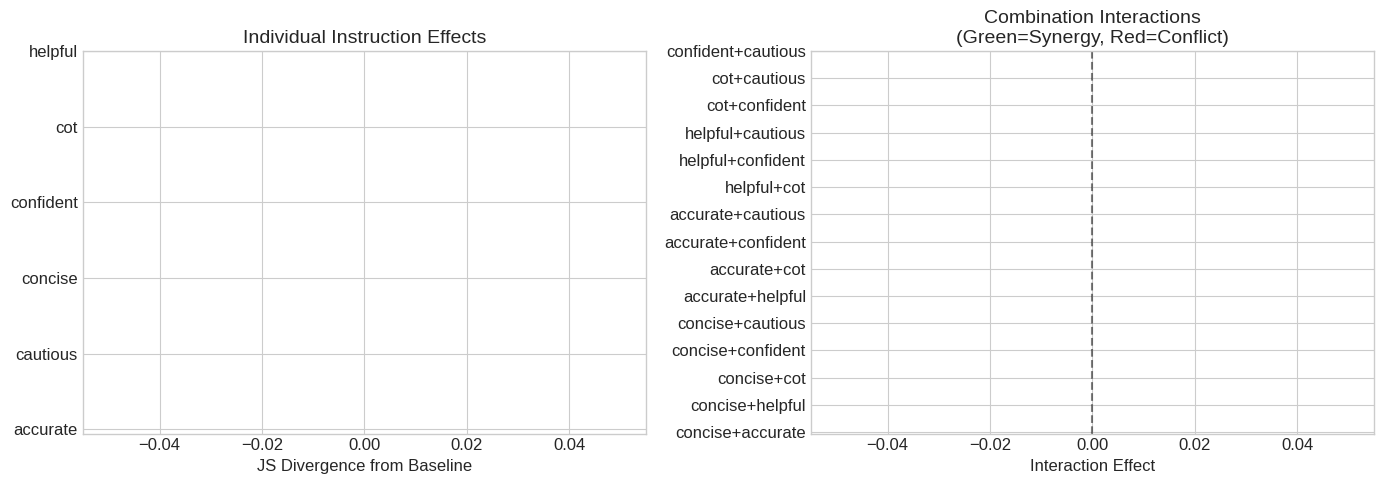

In [13]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual effects
ax = axes[0]
ind_data = config_effects.loc[individual_configs].sort_values('js_mean')
ax.barh(range(len(ind_data)), ind_data['js_mean'], xerr=ind_data['js_std'], capsize=3, alpha=0.7)
ax.set_yticks(range(len(ind_data)))
ax.set_yticklabels(ind_data.index)
ax.set_xlabel('JS Divergence from Baseline')
ax.set_title('Individual Instruction Effects')

# Interaction effects
ax = axes[1]
colors = ['green' if x == 'synergy' else 'red' if x == 'conflict' else 'gray' 
          for x in interaction_df['interaction_type']]
ax.barh(range(len(interaction_df)), interaction_df['interaction'], color=colors, alpha=0.7)
ax.set_yticks(range(len(interaction_df)))
ax.set_yticklabels(interaction_df['pair'])
ax.set_xlabel('Interaction Effect')
ax.set_title('Combination Interactions\n(Green=Synergy, Red=Conflict)')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../results/exp7_combinations.png', dpi=150)
plt.show()

In [14]:
print("\n=== Key Findings ===")
synergies = interaction_df[interaction_df['interaction_type'] == 'synergy']
conflicts = interaction_df[interaction_df['interaction_type'] == 'conflict']

print(f"Synergistic pairs: {len(synergies)}")
for _, row in synergies.iterrows():
    print(f"  • {row['pair']}")

print(f"\nConflicting pairs: {len(conflicts)}")
for _, row in conflicts.iterrows():
    print(f"  • {row['pair']}")


=== Key Findings ===
Synergistic pairs: 0

Conflicting pairs: 0


In [15]:
import json
with open('../results/exp7_results.json', 'w') as f:
    json.dump({
        "individual_effects": config_effects.loc[individual_configs].to_dict(),
        "interactions": interaction_df.to_dict('records')
    }, f, indent=2, default=float)
print("Saved.")

Saved.
